In [7]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import pandas as pd
import statsmodels.api as sm


import tqdm as tqdm
from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from joblib import Parallel, delayed

from functions.utils.system import *
from functions.utils.func import *
from prep_factor import PrepFactor 

import warnings

warnings.filterwarnings('ignore')

### Params

In [8]:
live = True
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
start = '2005-01-01'
window = 21
current_date = (date.today()).strftime('%Y-%m-%d')

### Execute PCA Loadings

In [9]:
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')

In [10]:
# Rolling Kmeans cluster parallel processing
@timebudget
def pca_load(data, window_size, num_components, name):
    # Make sure you copy the data before feeding it into rollingKmean or else it will take longer
    @ray.remote
    def exec_kmean(i, data, windowSize, n_clusters):
        # Get window data
        window_data = data.iloc[i:i + windowSize]

        # Standardize the data
        window_data = (window_data - window_data.mean()) / window_data.std()
        # Drop columns with if they have NAN values for more than half the column   
        window_data = window_data.drop(columns=window_data.columns[window_data.isna().sum() > len(window_data) / 2])
        window_data = window_data.fillna(0)

        # Run PCA and get loadings
        pca = PCA(n_components=num_components, random_state=42)
        pca.fit_transform(window_data)
        results_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

        # Create a dataframe that matches loadings to its respective stock
        df_loadings = pd.DataFrame(results_loadings, columns=[f'pcaLoading{name}_{i + 1}' for i in range(num_components)],
                                   index=window_data.columns)
        return df_loadings

    # Parallel Processing
    ray.init(num_cpus=16, ignore_reinit_error=True)
    load_list = ray.get([exec_kmean.remote(i, data, window_size, num_components) for i in range(0, len(data) - window_size + 1)])
    ray.shutdown()

    # Concat all the window loadings
    results_load = pd.concat(load_list, keys=data.index[window_size - 1:]).swaplevel()

    # Rearrange data to groupby ticker
    results_load.sort_index(level=[data.index.names[0], 'date'], inplace=True)
    results_load.columns = [f'load_{name}_{i}' for i in range(1, len(results_load.columns) + 1)]
    return results_load

In [11]:
# Get PCA General Componenets
price = create_return(price, [1])
pca_df = price['RET_01'].unstack(price.index.names[0])
num_components = 15
pca_data = pca_load(data=pca_df, window_size=window, num_components=num_components, name='eigen')

2023-11-01 22:41:45,809	INFO worker.py:1476 -- Calling ray.init() again after it has already been called.


pca_load took 175.861sec


In [12]:
pca_data = pca_data.replace([np.inf, -np.inf], np.nan)
pca_data = pca_data.fillna(0)
pca_data = pca_data.sort_index(level=['permno', 'date'])

### Divide by Volatility

In [13]:
T = [1]
for t in T:
    price[f'volatility_{t:02}'] = price.groupby('permno')[f'RET_{t:02}'].rolling(window=21).std().reset_index(level=0, drop=True)

### Calculate Eigenportfolios

In [14]:
combine = pd.merge(pca_data, price[['volatility_01', 'RET_01']], left_index=True, right_index=True, how='left')

In [15]:
# Create an empty DataFrame to store the sums for each factor
sums_by_date = pd.DataFrame(index=combine.index.get_level_values('date').unique())

# Normalize the weights first
# Divide each factor by its volatility
weights = combine.iloc[:, :-1].div(combine['volatility_01'], axis=0) 

# Sum of absolute values of weights for normalization
sum_of_abs_weights_by_date = weights.abs().groupby(level='date').sum()

# Normalize weights so that they sum up to 1 for each date
normalized_weights = weights.div(sum_of_abs_weights_by_date, axis=0, level='date')

# Now calculate the weighted returns using normalized weights
for factor in normalized_weights.columns:
    # Multiply the normalized weights by the returns column
    weighted_returns = normalized_weights[factor] * combine['RET_01']
    
    # Group by the date level of the MultiIndex and sum the values
    sum_by_date = weighted_returns.groupby(level='date').sum()
    
    # Store the result in the new DataFrame
    sums_by_date[factor] = sum_by_date

In [16]:
sums_by_date = sums_by_date.drop('volatility_01', axis=1)

### Get Epsilon

In [17]:
factor_col = sums_by_date.columns

In [18]:
for t in T:
    ret = f'RET_01'
    # if window size is too big it can create an index out of bound error (took me 3 hours to debug this error!!!)
    pca = rolling_ols_parallel(data=combine[['RET_01']], ret=ret, factor_data=sums_by_date, factor_cols=factor_col.tolist(), window=window, name=f'pca_{t:02}')

In [19]:
pca.columns

Index(['ALPHA_pca_01_21', 'load_eigen_1_pca_01_21', 'load_eigen_2_pca_01_21',
       'load_eigen_3_pca_01_21', 'load_eigen_4_pca_01_21',
       'load_eigen_5_pca_01_21', 'load_eigen_6_pca_01_21',
       'load_eigen_7_pca_01_21', 'load_eigen_8_pca_01_21',
       'load_eigen_9_pca_01_21', 'load_eigen_10_pca_01_21',
       'load_eigen_11_pca_01_21', 'load_eigen_12_pca_01_21',
       'load_eigen_13_pca_01_21', 'load_eigen_14_pca_01_21',
       'load_eigen_15_pca_01_21', 'epsil_pca_01_21', 'pred_pca_01_21',
       'resid_mom_21_pca_01_21', 'resid_mom_126_pca_01_21',
       'idio_vol_21_pca_01_21', 'idio_vol_126_pca_01_21'],
      dtype='object')

In [20]:
pca = pca[pca.columns[1:17]]

In [21]:
pca['Xk'] = pca[f'epsil_pca_01_{window:02}'].rolling(21).sum()
pca['Xk_lag'] = pca['Xk'].groupby('permno').shift(-1)
pca['Xk_diff'] = pca['Xk'].groupby('permno').diff()
pca = pca.fillna(0)

In [22]:
def process_stock(stock_data, ret, factor_col, window, stock_name, index_name):
    model_data = stock_data[[ret, factor_col]].fillna(0)
    rolling_ols = RollingOLS(endog=model_data[ret], exog=sm.add_constant(model_data[factor_col]), window=window)
    factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const': 'ALPHA'})
    result = factor_model.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    return result

def compute_betas_parallel(data, ret='Xk_diff', factor_col='Xk_lag', window=window, name='ss'):
    tasks = [(group, ret, factor_col, window, stock, data.index.names[0]) for stock, group in data.groupby(data.index.names[0])]
    results = Parallel(n_jobs=-1)(delayed(process_stock)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

betas = compute_betas_parallel(pca).droplevel(0)

In [23]:
betas.columns

Index(['ALPHA_ss_21', 'Xk_lag_ss_21'], dtype='object')

In [24]:
group = betas.copy(deep=True)
group.columns = ['a', 'b']
group = group.merge(pca[['Xk_diff', 'Xk_lag']], left_index=True, right_index=True, how='left')

In [25]:
group['kappa'] = -np.log(group['b']) * 252
group['m'] = group['a'] / (1 - group['b'])
group['sigma'] = np.sqrt(group['Xk_diff'].var() * 2 * group['kappa'] / (1 - group['b']**2))
group['sigma_eq'] = np.sqrt(group['Xk_diff'].var() / (1 - group['b']**2))
group['s_score'] = -group['m'] / group['sigma_eq']

mean_a = group['a'].mean()
group['m'] = mean_a / (1 - group['b'])
group['s_score_centered'] = (-group['a'] * np.sqrt(1 - group['b']**2) / (1 - group['b']) * np.sqrt(group['Xk_diff'].var()) + mean_a / (1 - group['b']) * np.sqrt(group['Xk_diff'].var())) / group['sigma_eq']

### Backtest

In [26]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

pca_multi = create_multi_index(sums_by_date, stock)

In [27]:
combined = group[['s_score']].merge(pca_multi, left_index=True, right_index=True, how='left')
combined = combined.merge(pca, left_index=True, right_index=True, how='left')
combined = combined.merge(combine[['RET_01']], left_index=True, right_index=True, how='left')
combined = combined.fillna(0)

In [28]:
combined.columns

Index(['s_score', 'load_eigen_1', 'load_eigen_2', 'load_eigen_3',
       'load_eigen_4', 'load_eigen_5', 'load_eigen_6', 'load_eigen_7',
       'load_eigen_8', 'load_eigen_9', 'load_eigen_10', 'load_eigen_11',
       'load_eigen_12', 'load_eigen_13', 'load_eigen_14', 'load_eigen_15',
       'load_eigen_1_pca_01_21', 'load_eigen_2_pca_01_21',
       'load_eigen_3_pca_01_21', 'load_eigen_4_pca_01_21',
       'load_eigen_5_pca_01_21', 'load_eigen_6_pca_01_21',
       'load_eigen_7_pca_01_21', 'load_eigen_8_pca_01_21',
       'load_eigen_9_pca_01_21', 'load_eigen_10_pca_01_21',
       'load_eigen_11_pca_01_21', 'load_eigen_12_pca_01_21',
       'load_eigen_13_pca_01_21', 'load_eigen_14_pca_01_21',
       'load_eigen_15_pca_01_21', 'epsil_pca_01_21', 'Xk', 'Xk_lag', 'Xk_diff',
       'RET_01'],
      dtype='object')

In [57]:
ret_columns = [f'load_eigen_{i}' for i in range(1, 16)]
beta_columns = [f'load_eigen_{i}_pca_01_{window:01}' for i in range(1, 16)]
combined = combined[['s_score', 'RET_01'] + ret_columns + beta_columns]

-

In [58]:
def compute_trading_signal(data, sbo, sso, sbc, ssc):
    def apply_rules(group):
        position = None
        signals = []

        for s_score in group['s_score']:
            if position is None:
                if s_score < -sbo:
                    position = 'buy'
                    signals.append('buy to open')
                elif s_score > sso:
                    position = 'sell'
                    signals.append('sell to open')
                else:
                    signals.append(None)
            elif position == 'buy':
                if s_score > -ssc:
                    position = None
                    signals.append('close long')
                else:
                    signals.append('hold')
            elif position == 'sell':
                if s_score < sbc:
                    position = None
                    signals.append('close short')
                else:
                    signals.append('hold')
            else:
                signals.append(None)

        return pd.Series(signals, index=group.index)

    # Sort data by permno and date for consistency
    data = data.sort_values(by=['permno', 'date'])
    # Group by permno and apply the rules for each group
    data['signal'] = data.groupby('permno').apply(lambda x: apply_rules(x)).reset_index(level=0, drop=True)
    return data

\

In [59]:
sbo = -0.5
sso = -1.00
sbc = 1.00
ssc = 0.5
result = compute_trading_signal(combined, sbo, sso, sbc, ssc)

-

\

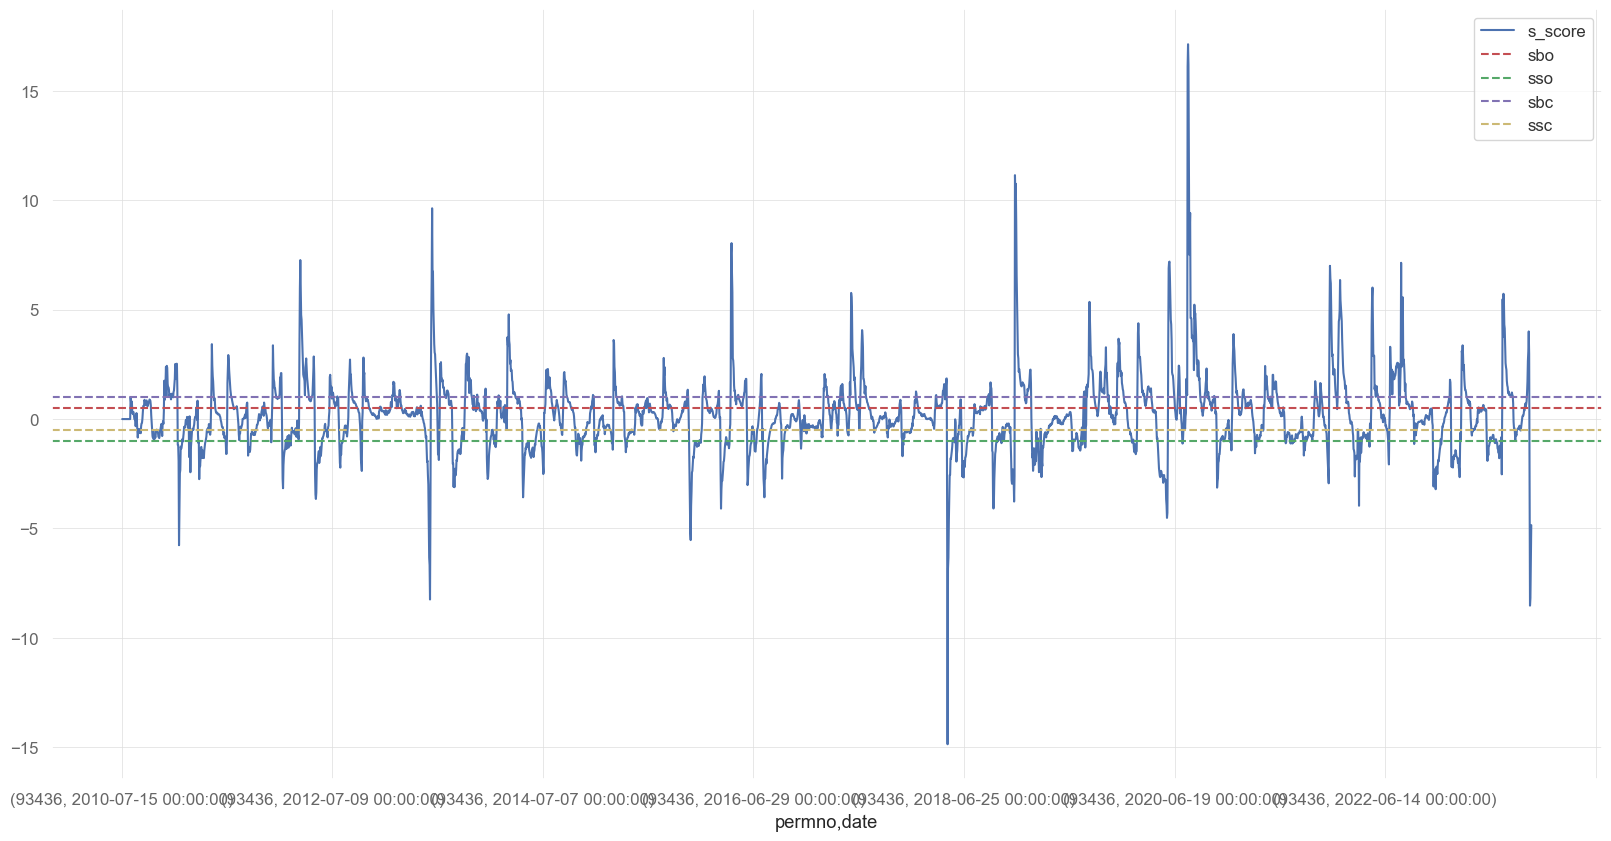

|

In [60]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 10))
# Plot the s_score
get_stock_data(combined, 93436).s_score.plot(ax=ax)
# Plot the threshold lines
ax.axhline(y=-sbo, color='r', linestyle='--', label='sbo')
ax.axhline(y=sso, color='g', linestyle='--', label='sso')
ax.axhline(y=sbc, color='m', linestyle='--', label='sbc')
ax.axhline(y=-ssc, color='y', linestyle='--', label='ssc')
# Add legend
ax.legend()
# Display the plot
plt.show()

In [61]:
def compute_portfolio_returns(df):
    # Map signal to its corresponding position
    position_map = {
        'buy to open': 'long',
        'sell to open': 'short',
        'close long': 'close long',
        'close short': 'close short'
    }
    
    # Create a 'position' column based on 'signal' column
    df['position'] = df['signal'].map(position_map)
    
    # Forward fill the long/short positions until a close signal
    df['position'] = df['position'].where(df['position'].str.contains('close'), df['position'].ffill())
    
    # Create a shifted position column to identify the initial signals
    df['shifted_position'] = df['position'].shift(1)
    
    # Extract all beta columns and compute the cumulative hedge return
    beta_columns = [col for col in df.columns if '_sector_' in col]
    hedge_return = sum(df[beta] * df[beta.split('_sector_')[0].replace('_sector_', '')] for beta in beta_columns)

    # Create conditions
    long_condition = df['position'] == 'long'
    short_condition = df['position'] == 'short'
    close_long_condition = df['position'] == 'close long'
    close_short_condition = df['position'] == 'close short'
    initial_long_condition = (df['position'] == 'long') & (df['shifted_position'] != 'long')
    initial_short_condition = (df['position'] == 'short') & (df['shifted_position'] != 'short')
    
    # Compute portfolio returns
    df['portfolio_return'] = np.where(initial_long_condition | initial_short_condition, 0,
                                      np.where(long_condition, df['RET_01'] - hedge_return, 
                                               np.where(short_condition, -df['RET_01'] + hedge_return, 
                                                        np.where(close_long_condition, df['RET_01'] - hedge_return, 
                                                                 np.where(close_short_condition, -df['RET_01'] + hedge_return, 0)))))

    # Clean up the helper columns
    df.drop(['position', 'shifted_position'], axis=1, inplace=True)
    return df['portfolio_return']

In [62]:
result['portfolio_return'] = result.groupby(level=0).apply(compute_portfolio_returns).reset_index(level=0, drop=True)

/

In [63]:
def validate_signals(signals):
    buy_to_open_count = signals[signals == 'buy to open'].count()
    close_long_count = signals[signals == 'close long'].count()
    sell_to_open_count = signals[signals == 'sell to open'].count()
    close_short_count = signals[signals == 'close short'].count()
    if buy_to_open_count != close_long_count:
        return f"Buy to Open: {buy_to_open_count}, Close Long: {close_long_count}"
    if sell_to_open_count != close_short_count:
        return f"Sell to Open: {sell_to_open_count}, Close Short: {close_short_count}"
    return "Balanced"

In [64]:
signal_counts = result.groupby(level=0)['signal'].apply(validate_signals)
imbalanced_signals = signal_counts[signal_counts != "Balanced"]
print(imbalanced_signals)

/permno
10078      Sell to Open: 71, Close Short: 70
10104    Buy to Open: 1790, Close Long: 1789
10145    Buy to Open: 1880, Close Long: 1879
10147    Buy to Open: 1046, Close Long: 1045
10258      Buy to Open: 766, Close Long: 765
                        ...                 
93246      Buy to Open: 908, Close Long: 907
93299      Buy to Open: 666, Close Long: 665
93312    Buy to Open: 1160, Close Long: 1159
93384      Buy to Open: 675, Close Long: 674
93436      Buy to Open: 609, Close Long: 608
Name: signal, Length: 712, dtype: object


In [65]:
# Get the first date of each year
first_dates_per_year = result.reset_index().groupby(result.index.get_level_values('date').year)['date'].first()

# Map these first dates to the number of stocks at the beginning of the year
stocks_count_dict = {date: len(get_stock_idx(set_timeframe(result, str(date.year), str(date.year + 1)))) for date in first_dates_per_year}

# Use the map function to quickly assign the number of stocks for each date
result['num_stocks_start_year'] = result.index.get_level_values('date').map(stocks_count_dict)
result['num_stocks_start_year'] = result['num_stocks_start_year'].ffill()

result['weight'] = 1 / result['num_stocks_start_year']
result['weighted_portfolio_return'] = result['weight'] * result['portfolio_return']
daily_portfolio_return = result.groupby(level=1)['weighted_portfolio_return'].sum()

/

## Plot

[*********************100%%**********************]  1 of 1 completed
|

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-02-03   2005-02-03
End Period                 2023-10-31   2023-10-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          250.63%      50.68%
CAGR﹪                     4.73%        1.52%

Sharpe                     0.44         0.28
Prob. Sharpe Ratio         97.18%       88.79%
Smart Sharpe               0.41         0.26
Sortino                    0.62         0.4
Smart Sortino              0.58         0.37
Sortino/√2                 0.44         0.28
Smart Sortino/√2           0.41         0.26
Omega                      1.06         1.06

Max Drawdown               -56.47%      -32.7%
Longest DD Days            1982         2142
Volatility (ann.)          19.45%       9.34%
R^2                        0.01         0.01
Information Ratio          -0.02        -0.02
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-12,2009-03-27,2013-10-22,2142,-32.700861,-31.662100
2,2020-02-14,2020-03-19,2021-03-15,396,-19.019722,-17.159863
3,2015-03-24,2016-02-12,2016-04-28,402,-10.979549,-9.792037
4,2022-08-18,2022-10-03,2022-11-30,105,-8.069885,-7.679387
5,2023-08-02,2023-10-30,2023-10-31,91,-6.489951,-6.003465


|

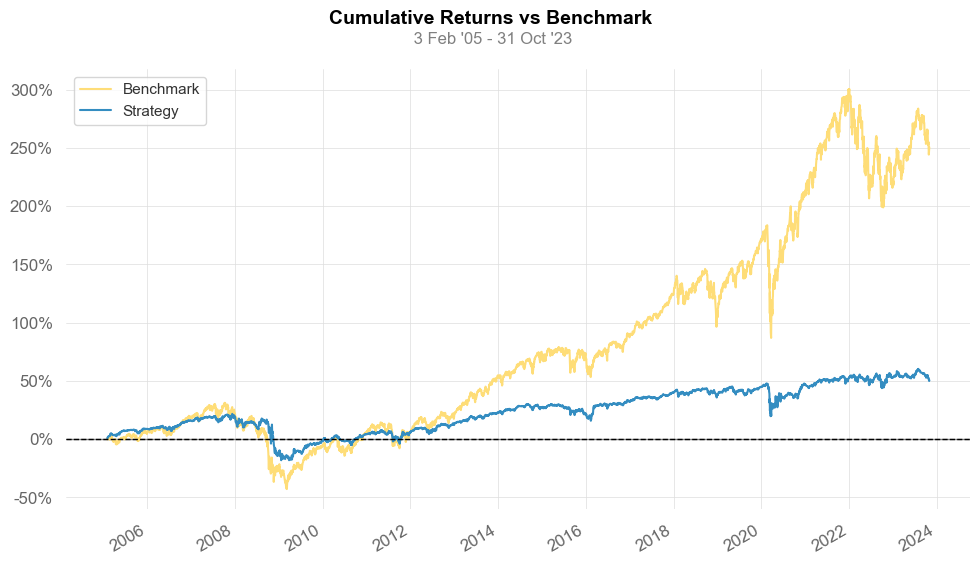

-

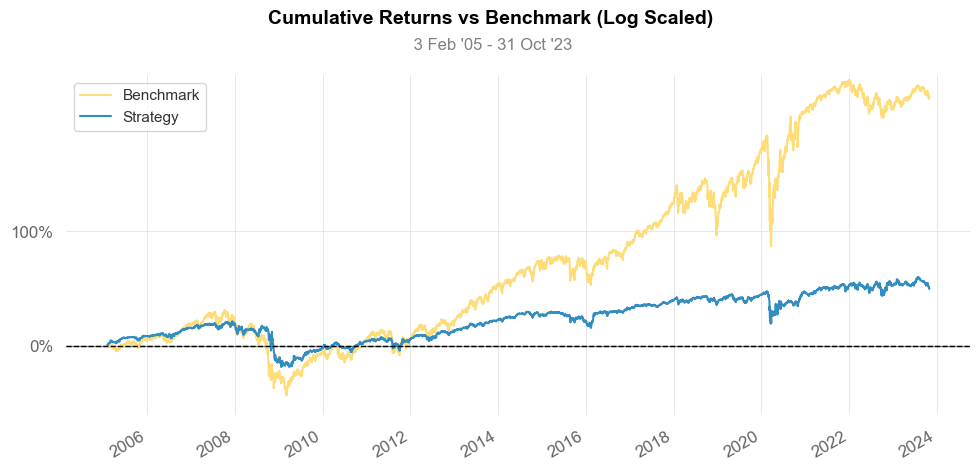

\

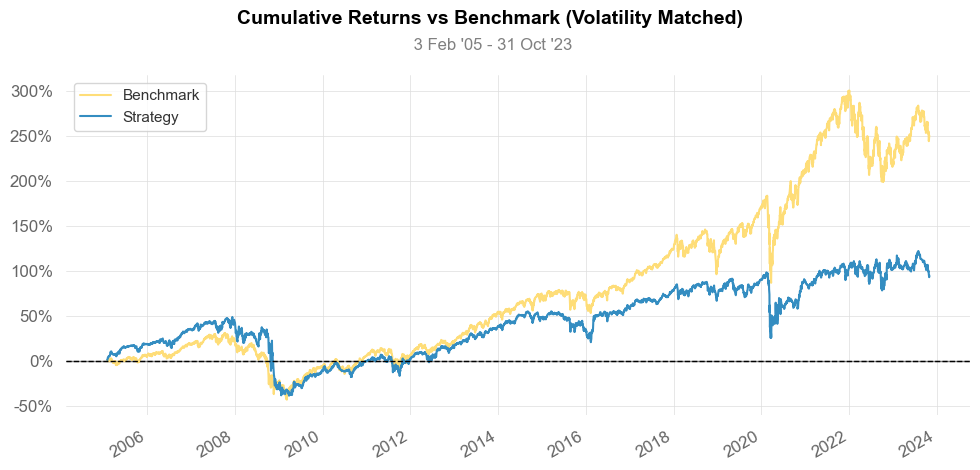

/

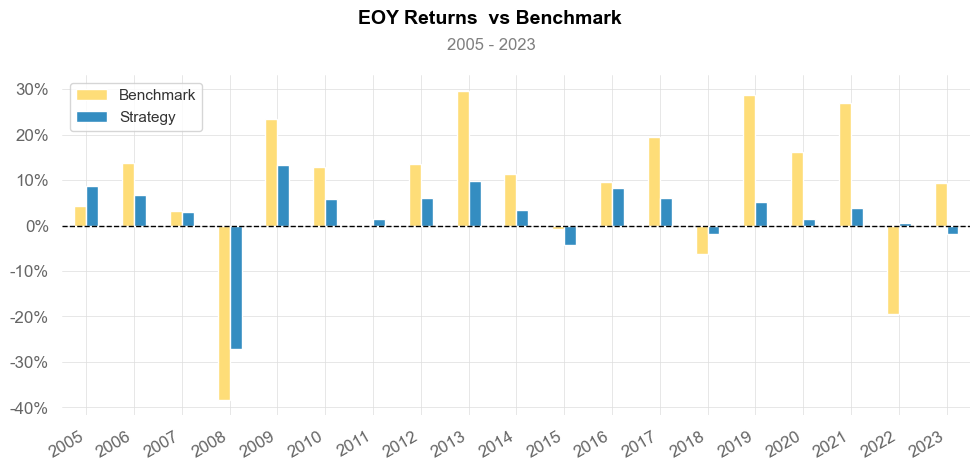

-

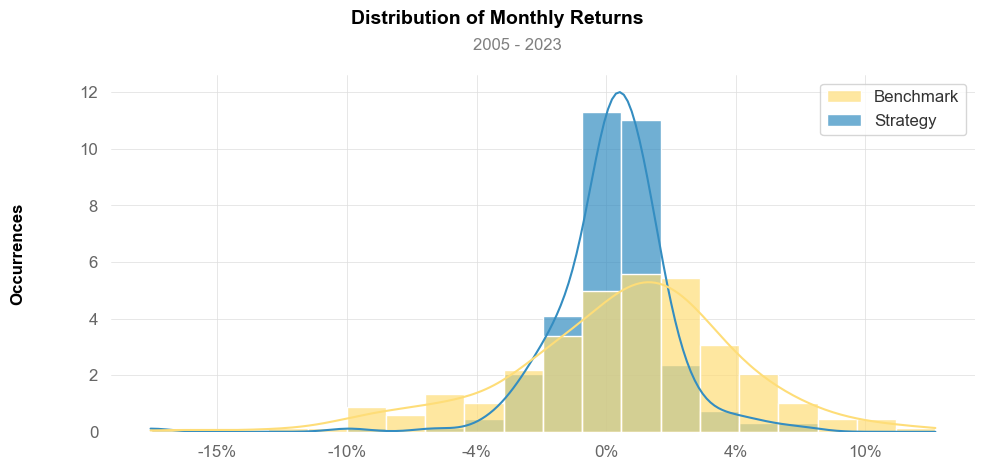

\

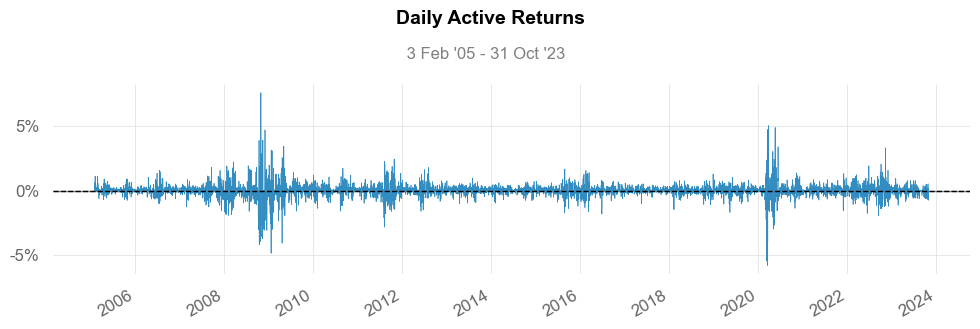

/

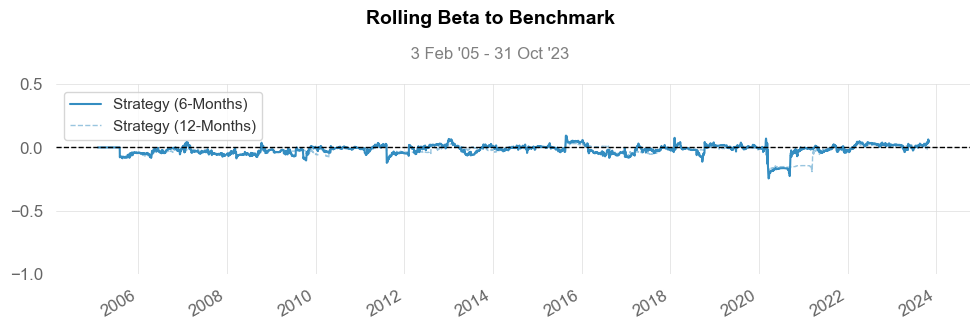

\

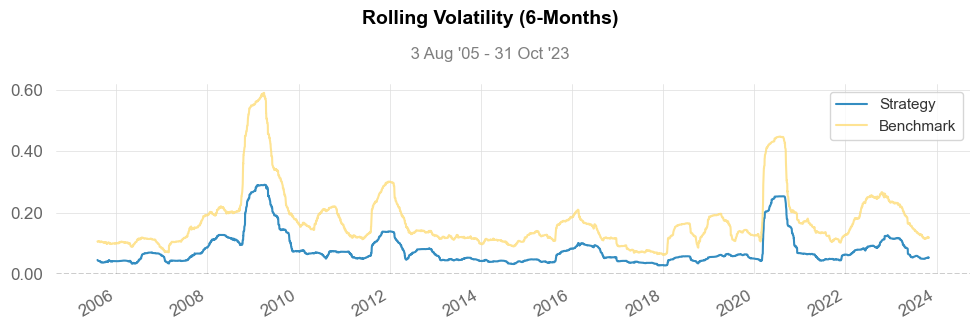

|

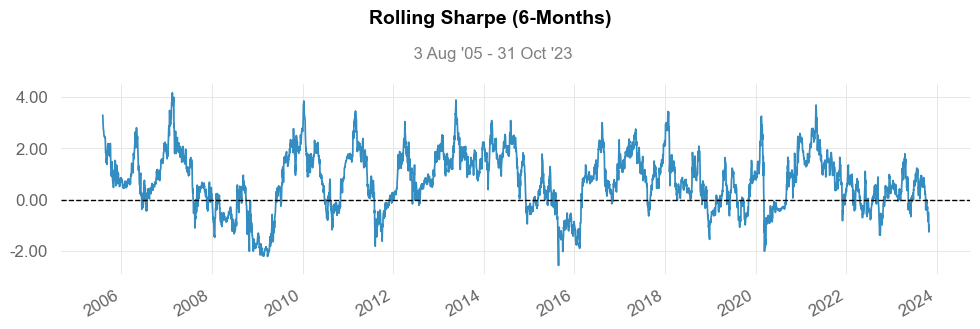

-

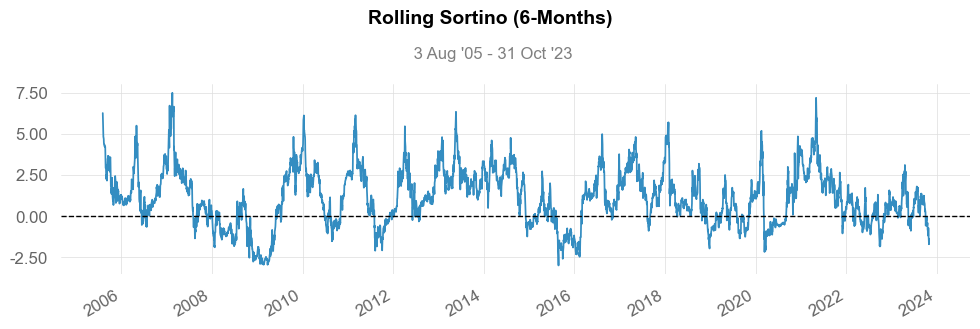

|

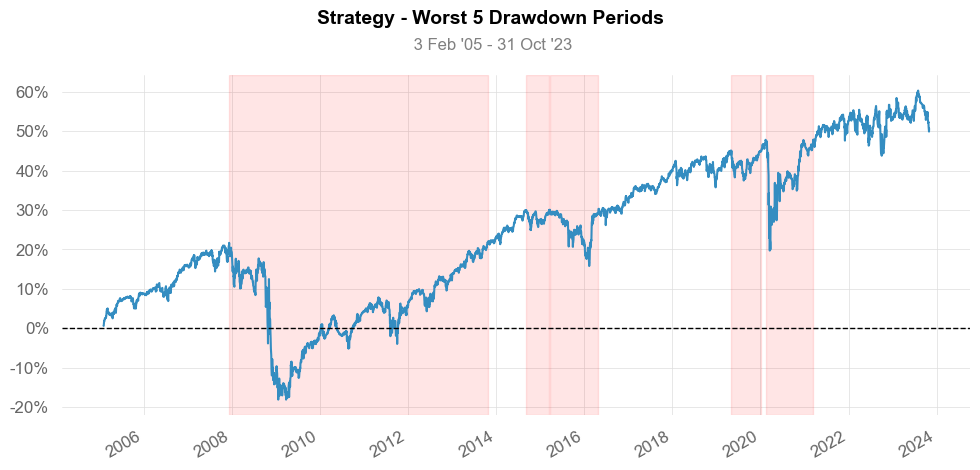

-

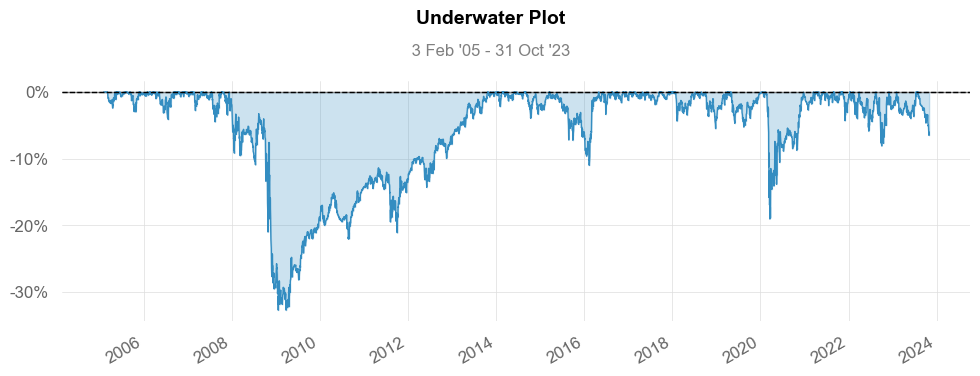

\

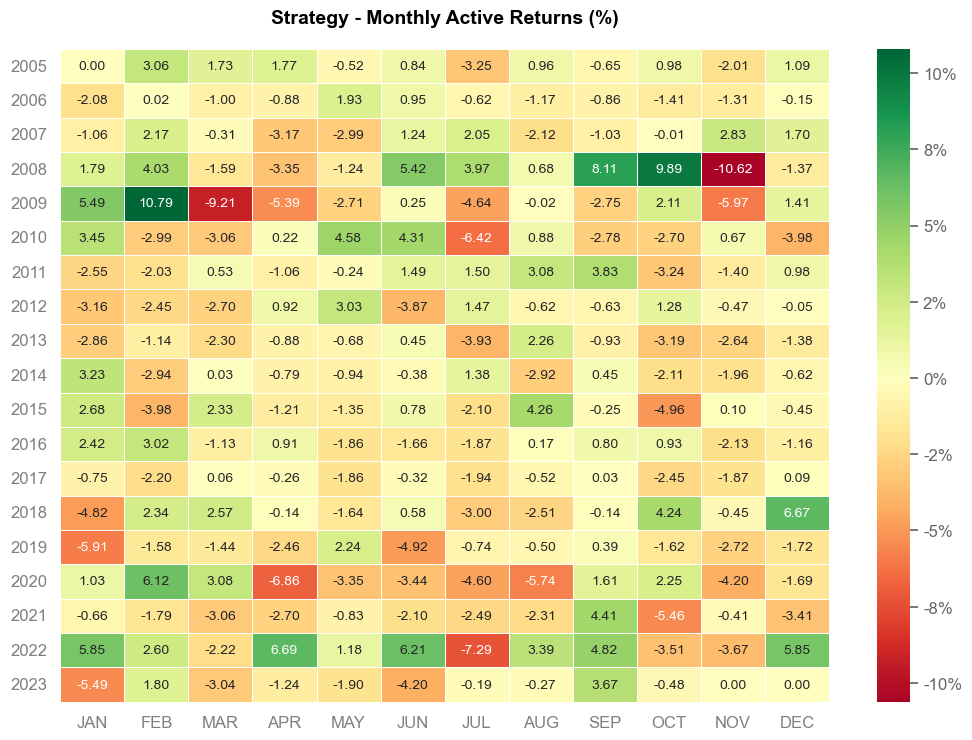

|

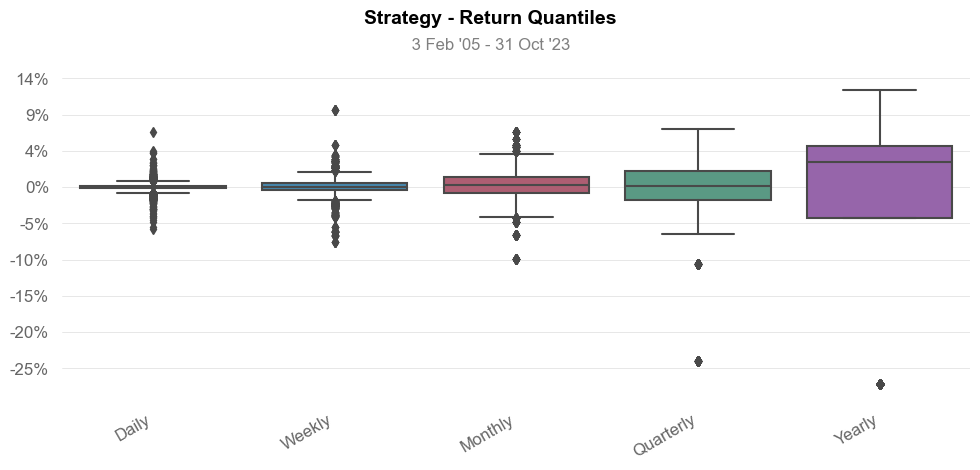

\

In [66]:
qs.reports.full(daily_portfolio_return, "SPY", figsize=(10, 5))